# Queue configuration check

Verify online configuration changes of 802.11e queue parameters

Refer to https://wireless.wiki.kernel.org/en/developers/documentation/mac80211/queues for information about queue mapping.

## Default configs

### tx_queue
These parameters are used by the access point when transmitting frames to the clients.

#### Low priority / AC_BK = background
```
tx_queue_data3_aifs=7
tx_queue_data3_cwmin=15
tx_queue_data3_cwmax=1023
tx_queue_data3_burst=0
```

#### Normal priority / AC_BE = best effort
```
tx_queue_data2_aifs=3
tx_queue_data2_cwmin=15
tx_queue_data2_cwmax=63
tx_queue_data2_burst=0
```

#### High priority / AC_VI = video
```
tx_queue_data1_aifs=1
tx_queue_data1_cwmin=7
tx_queue_data1_cwmax=15
tx_queue_data1_burst=3.0
```

#### Highest priority / AC_VO = voice
```
tx_queue_data0_aifs=1
tx_queue_data0_cwmin=3
tx_queue_data0_cwmax=7
tx_queue_data0_burst=1.5
```

### wmm
The parameters will be used by WMM clients for frames transmitted to the access point.

#### Low priority / AC_BK = background
```
wmm_ac_bk_cwmin=4
wmm_ac_bk_cwmax=10
wmm_ac_bk_aifs=7
wmm_ac_bk_txop_limit=0
wmm_ac_bk_acm=0
```

#### Normal priority / AC_BE = best effort
```
wmm_ac_be_aifs=3
wmm_ac_be_cwmin=4
wmm_ac_be_cwmax=10
wmm_ac_be_txop_limit=0
wmm_ac_be_acm=0
```

#### High priority / AC_VI = video
```
wmm_ac_vi_aifs=2
wmm_ac_vi_cwmin=3
wmm_ac_vi_cwmax=4
wmm_ac_vi_txop_limit=94
wmm_ac_vi_acm=0
```

#### Highest priority / AC_VO = voice
```
wmm_ac_vo_aifs=2
wmm_ac_vo_cwmin=2
wmm_ac_vo_cwmax=3
wmm_ac_vo_txop_limit=47
wmm_ac_vo_acm=0
```

## Downstream
Change configuration of tx_queues.

Traffic is generated from AP to clients.

Default parameters obtained with `get_queue_params`:
```
Queue=0 : aifs=1 tx_cwmin=3 tx_cwmax=7 burst=15
Queue=1 : aifs=1 tx_cwmin=7 tx_cwmax=15 burst=30
Queue=2 : aifs=3 tx_cwmin=15 tx_cwmax=63 burst=0
Queue=3 : aifs=7 tx_cwmin=15 tx_cwmax=1023 burst=0
```

### Step 0: sync time on AP and Client
`ntpdate pool.ntp.br`

### Step 1: set TOS

Map AP traffic with dport **5201** to **VO** queue:
```
iptables -t mangle -A OUTPUT -o wlp4s0 -d 10.0.0.2/32 -p tcp --dport 5201 -j TOS --set-tos 224
iptables -t mangle -A PREROUTING -i wlp4s0 -d 10.0.0.2/32 -p tcp --dport 5201 -j TOS --set-tos 224
```

Map AP traffic with dport **5202** to **BK** queue:
```
iptables -t mangle -A OUTPUT -o wlp4s0 -d 10.0.0.2/32 -p tcp --dport 5202 -j TOS --set-tos 64
iptables -t mangle -A PREROUTING -i wlp4s0 -d 10.0.0.2/32 -p tcp --dport 5202 -j TOS --set-tos 64
```

### Step 2: run iperf

We are going to run two instances of iperf

Client terminal 1:
`iperf3 -s -p 5201 -i 0.1 -J > iperf-server-5201.json`

Client terminal 2:
`iperf3 -s -p 5202 -i 0.1 -J > iperf-server-5202.json`


AP terminal 1:
`iperf3 -c 10.0.0.2 -p 5201 -t 0 -i 0.1 -J > iperf-client-5201.json`

AP terminal 2:
`iperf3 -c 10.0.0.2 -p 5202 -t 0 -i 0.1 -J > iperf-client-5202.json`

Run `run_test.sh` (see script contents below).

Copy server results and run `json_iperf.py` (see contents below) with:

`./json_iperf.py -f iperf-server-520X.json`

This will generate `iperf-server-520X.h5` with the results.

## Analysis with TCP traffic

In [43]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [46]:
term1 = pd.read_hdf('tcp-iperf-server-5201.h5')
term2 = pd.read_hdf('tcp-iperf-server-5202.h5')
tputs = pd.merge_asof(term1, term2, on='timestamp_seg')
tputs = tputs.dropna()

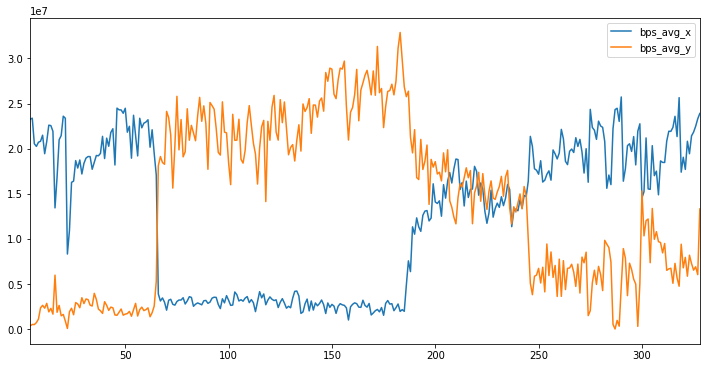

In [47]:
tputs[['bps_avg_x', 'bps_avg_y']].plot()

## Analysis with UDP traffic

Map AP traffic with dport **5201** to **VO** queue:
```
iptables -t mangle -A OUTPUT -o wlp4s0 -d 10.0.0.2/32 -p udp --dport 5201 -j TOS --set-tos 224
iptables -t mangle -A PREROUTING -i wlp4s0 -d 10.0.0.2/32 -p udp --dport 5201 -j TOS --set-tos 224
```

Map AP traffic with dport **5202** to **BK** queue:
```
iptables -t mangle -A OUTPUT -o wlp4s0 -d 10.0.0.2/32 -p udp --dport 5202 -j TOS --set-tos 64
iptables -t mangle -A PREROUTING -i wlp4s0 -d 10.0.0.2/32 -p udp --dport 5202 -j TOS --set-tos 64
```

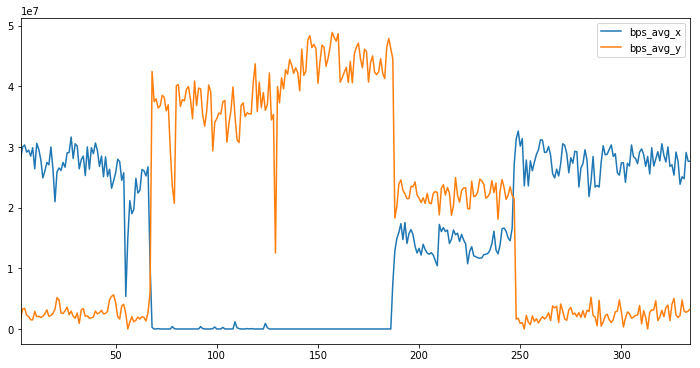

In [54]:
term1 = pd.read_hdf('iperf-server-5201.h5')
term2 = pd.read_hdf('iperf-server-5202.h5')
tputs = pd.merge_asof(term1, term2, on='timestamp_seg')
tputs = tputs.dropna()
tputs[['bps_avg_x', 'bps_avg_y']].plot()

# TODO
Further tests:

    1) Do the same experiments with traffic from stations to AP, and setting WMM queues (`set_wmm_params`).
    
    2) Perform all the experiments with more than one station, instead of two iperf instances running on the same station.

# run_test.sh
```
#!/bin/bash

sleep 60

# Set VO to work like BK
echo "Setting set_queue_params 0 7 15 1023 0"
./hostapd_cli set_queue_params 0 7 15 1023 0

sleep 60

# Set BK to work like VO (original)
echo "Setting set_queue_params 3 1 3 7 15"
./hostapd_cli set_queue_params 3 1 3 7 15

sleep 60

# Set VO to work like VO (original)
echo "Setting set_queue_params 0 1 3 7 15"
./hostapd_cli set_queue_params 0 1 3 7 15

sleep 60

# Set BK to work like BK (original)
echo "Setting set_queue_params 3 7 15 1023 0"
./hostapd_cli set_queue_params 3 7 15 1023 0

sleep 60
```

# json_iperf.py
```
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Module extract
# This module reads iperf generated .json files and extracts information
# from it.
#
from __future__ import print_function
import json
import operator
import argparse
import numpy as np
import pandas as pd
from re import split
from codecs import open
from copy import deepcopy
from os.path import exists
from functools import reduce


def sort_table(table, cols):
    """ sort a table by multiple columns
        table: a list of lists (or tuple of tuples) where each inner list
               represents a row
        cols:  a list (or tuple) specifying the column numbers to sort by
               e.g. (1,0) would sort by column 1, then by column 0
    """
    if len(table) == 0:
        return table
    m = len(table[0])  # number of columns
    for i in cols:
        if i >= m or i < 0:
            print("Error: index to sort has a wrong value %f" % i)
            return table
    for col in reversed(cols):
        table = sorted(table, key=operator.itemgetter(col))
    return table


def stringify(list_of_strings):
    return reduce(lambda x, y: x + ',' + y, list_of_strings)


def decode_json(filename):
    result = {}
    if not exists(filename):
        print("Didn't find", filename)
    else:
        with open(filename, 'r', 'utf-8') as f:
            # print 'Reading', filename
            raw_string = f.read()
        spl = split('}\n{', raw_string)
        try:
            if len(spl) > 1:
                result = json.loads(spl[0] + '}')
            else:
                result = json.loads(spl[0])
        except json.decoder.JSONDecodeError:
            result = []
    return result


def get_traffic_type(json_file):
    try:
        start = json_file['start']
    except Exception as e:
        print("Key 'start' not found in JSON Results", e)
        return -1
    try:
        start = start['test_start']
    except Exception as e:
        print("Key 'test_start' not found in JSON Results' 'start' field", e)
        return -1
    try:
        return start['protocol']
    except Exception as e:
        print("No protocol found for file", e)
        return -1


def make_table(filename, verbose=False):
    """ :return result: matrix (list)
    """
    json_result = decode_json(filename)

    try:
        intervals = json_result['intervals']
    except Exception as e:
        print("Key 'intervals' not found in JSON Results", e)
        return [], []

    if(len(intervals) == 0):
        print("Empty intervals on JSON Results", filename)
        return [], []
    try:
        # header_sum = list(intervals[0]['sum'].keys())
        header_streams = ["stream"] + list(intervals[0]['streams'][0].keys())
    except Exception as e:
        print("Could not get header from intervals", e)
        return [], []

    # MATHEUS: verificar o tipo do tráfego !!!!
    trafego = get_traffic_type(json_result)
    # print 'Tipo do trafego é:  ', trafego

    # Filter streams
    streams = []
    streamlen = len(intervals[0]['streams'])
    for i in range(streamlen):
        streams += list(map(lambda x: [i] + list(x['streams'][i].values()),
                            intervals))
    sums = list(map(lambda x: list(x['sum'].values()), intervals))
    if(len(streams) != len(sums)):
        print("ERROR: length of streams is different from length of sums")
        return [], []

    # gerar métricas a partir das colunas:
    # * bits_per_second: média, min, max
    # * bytes: soma
    # * packets: soma
    # * omitted: soma
    ts_index = header_streams.index('timestamp_seg')
    m_streams = np.array(streams, dtype=np.float64)

    # select unique timestamps
    m_ts = np.unique(m_streams[:, ts_index])

    # first row in the result is the timestamps
    result = deepcopy(m_ts).reshape((m_ts.shape[0], 1))
    result_headers = ['timestamp_seg']  # save the header description

    # process_columns contains the aggregation metrics for each column
    # format: each line contains [nome da coluna que será afetada, função,
    # nome da nova coluna]
    process_columns = [['bits_per_second', np.nanmean, 'bps_avg'],
                       ['bits_per_second', np.nanmin, 'bps_min'],
                       ['bits_per_second', np.nanmax, 'bps_max'],
                       ['bits_per_second', np.nanstd, 'bps_std'],
                       # ['bytes', np.nansum, 'bytes'],
                       # ['packets', np.nansum, 'packets'],
                       # ['omitted', np.nansum, 'omitted'],
                       # ['delay_ms', np.nanmean, 'delay_avg'],
                       # ['delay_ms', np.nanmin, 'delay_min'],
                       # ['delay_ms', np.nanmax, 'delay_max'],
                       # ['jitter_ms', np.nanmean, 'jitter_avg'],
                       # ['jitter_ms', np.nanmin, 'jitter_min'],
                       # ['jitter_ms', np.nanmax, 'jitter_max'],
                       # ['retransmits', np.nansum, 'retransmits_sum'],
                       # ['rtt', np.nanmean, 'rtt_avg'],
                       # ['rtt', np.nanmin, 'rtt_min'],
                       # ['rtt', np.nanmax, 'rtt_max'],
                       # ['lost_percent', np.nanmean, 'lpct_avg'],
                       # ['lost_percent', np.nanmin, 'lpct_min'],
                       # ['lost_percent', np.nanmax, 'lpct_max'],
                       ]

    # Caso o tráfego seja TCP, contamos pacotes perdidos pelo retransmits...
    # if trafego == 'UDP':
    #     process_columns.append(['lost_packets', np.nansum, 'lost_packets'])
    # else:
    #     process_columns.append(['retransmits', np.nansum, 'lost_packets'])

    # MATHEUS: olhe o campo lost_percent
    #          acho que tem que fazer a conta com as colunas
    #          lost_packets / packets, depois do agrupamento

    for c, f, col_name in process_columns:
        try:
            idx = header_streams.index(c)  # index of the desired column
        except ValueError:
            # col is not in stream
            idx = -1

        if idx > 0:
            transformed_column = \
                np.array(list(map(lambda i:
                              f(m_streams[i == m_streams[:, ts_index], idx]
                                ),
                              m_ts
                              )
                              )
                         )
        else:
            # gerar coluna com NA
            transformed_column = np.full((result.shape[0]), np.nan)
        # insert column
        # insert after last column
        result = np.insert(result, result.shape[1], transformed_column, axis=1)
        result_headers.append(col_name)  # save column name

    # MATHEUS: tem que inserir uma coluna identificando se o tráfego
    # foi UDP ou TCP
    # transformed_column = np.full((result.shape[0]), -1) \
    #     if trafego == 'UDP' else np.ones((result.shape[0]))
    # # insert after last column
    # result = np.insert(result, result.shape[1], transformed_column, axis=1)
    # result_headers.append('traffic_type')  # save column name

    # convert result to list
    result = list(result)
    for i in range(len(result)):
        result[i] = list(result[i])

    return result_headers, result


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extracts information from \
                                     capture files')
    parser.add_argument('-f', '--filename', type=str, help='pcap filename',
                        required=True)
    args = parser.parse_args()

    header_streams, streams = make_table(args.filename)

    df = pd.DataFrame(streams, columns=header_streams)

    df.to_hdf(args.filename.replace('json', 'h5'), mode='w', key='df')

    # print(header_streams, streams)
    # for i in range(len(streams)):
    #     print streams[i]

```